# Linear model calibration
## Purpose
The purpose of this notebook is to implement the calibration of a simple linear model. The parameters that are calibrated are the slope (m) and the offset (b). In simple terms, we want to find the distribution of m and b (our parameters of interest) that fit the model onto the data. This in statistics terms is called the posterior distribution of the parameters i.e. given the data, what is the probability distribution of the parameters ($p(Q|X)$ where Q is the vector of parameters and X is the data)
## Description
### Data
For data we generate data using a known slope and offset. We use m = 5 and b = 8. However to make the data realistic, random noise of the form $\varepsilon \sim N(0,\sigma^2)$. We choose $\sigma = 0.1$.
### Model
To this data we fit a linear model of the form $F([m,b]) = mx + b$ and find the distribution of m and b (posterior distributions).

In [136]:
#import
import numpy as np
from pymcmcstat.MCMC import MCMC
import matplotlib.pyplot as plt

### Generate fake data

In [137]:
#generate 100 x points uniformly from 0 to 1
x = np.linspace(0,1,num=100)
m_real = 5.
b_real = 8.
noise_sigma = 0.5
#uncomment to set seed
#np.random.seed(1)
# y given by mx + b and then perturbed by normally distributed noise of std_dev = 0.7 = noise_sigma and mean = 0
y = m_real * x + b_real + (np.random.normal(loc = 0.,scale = (noise_sigma)**2,size = x.shape))

### Plot of the artificially generated data

Text(0.5, 1.0, 'Artifically generated data')

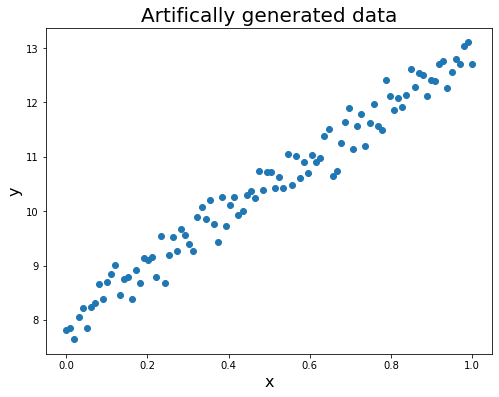

In [156]:
fig = plt.figure(figsize = (8,6))
ax = fig.gca()
artd = ax.scatter(x,y)
ax.set_xlabel('x',fontsize = 16)
ax.set_ylabel('y',fontsize = 16)
ax.set_title('Artifically generated data',fontsize = 20)

## Defining our linear model

In [158]:
def model(data,q):
    m,b = q
    x = data.xdata[0]
    return m*x + b
    

### Initialize mcmc object and add our fake dataset

In [139]:
mcstat = MCMC()
mcstat.data.add_data_set(x,y)

## Sum of squares function
The sum of squares error is used in evaluating the likelihood function and is given by $$\sum_{i=1}^{N_{obs}}[F^{obs}(i) - F(i;q)]^2$$ where $F^{obs}$ is the observed data y and $F(i;q)$is our linear model.
### What is a likelihood function
The likelihood function basically defines the probability of observing the data given a paticular parameter set ($L(F^{obs}|q)$).
Since the statistical model we assumed is guassian in nature ($F^{obs}(i) = F(i;q) + \varepsilon_{i}$), our likelihood function turns out to be $$L(F^{obs}|q) = e^{-\frac{SS_{q}}{2\sigma^2}}$$ where $SS_{q}$ is the sum of squares error defined earlier. 
This basically tells us that the likelyhood of observing the data we have observed for a paticular parameter set (m,b) we choose decreses as the sum os squares error increases.
This will be used by the meteropolis algorithm when its accepting or rejecting a paticular parameter set in the Markov Chain

In [159]:
#defining the sum of squares function
def ssfun(q,data):
    m,b  = q #slopt and offset are set as the parameters q
    x = data.xdata[0] #extracting the xdata from the data datastructure
    y = data.ydata[0] #extracting the ydata from the data datastructure
    
    y_model = model(data,q)
    
    ssq = ((y - y_model)**2).sum(axis = 0)
    return ssq

We now define the model settings where we define the sum of squares function and the prior function (if any). This prior function is by default the uniform distribution. We dont want to change that here and are hence not providing a prior function

In [141]:
mcstat.model_settings.define_model_settings(sos_function=ssfun)

Let us now define the simulation settings.There are a host of simulation settings that can be set here for ex. number of parameter samples to simulate, the type of algorithm to use (Metropolis- Hastings, Adaptive Metropolis, Delayed Rejection and DRAM) and a lot of different options for each algorithm 
To start of, we will use the standard DRAM algorithm as thats the one used in the paper. This book contains a lot of information about the different algorithms - https://drive.google.com/file/d/1ibBNl2KmQz2scQ_D7ntT_JFWQSc3eXBp/view?usp=sharing


In [142]:
mcstat.simulation_options.define_simulation_options(nsimu = 10.0e4,method = 'dram')

We now give the mcmc object our model parameters and an initial value. An initial value is a requirement.
We can also provide a maximum and minimum value as well as a mean and a standard deviation if we are defining a normal prior distribution. For this tutorial, we will provide an initial value and a lower and upper limit. However, we are providing a uniform prior distribution and thus dont need to define the mean and standard deviation

In [143]:
#add parameter m
mcstat.parameters.add_model_parameter(name = 'm',theta0 = 3.) #theta0 is the initial value
mcstat.parameters.add_model_parameter(name = 'b',theta0 = 6.)

### Run the simulation

In [144]:
mcstat.run_simulation()


Sampling these parameters:
      name      start [      min,       max] N(       mu,   sigma^2)
         m:      3.00 [     -inf,       inf] N( 0.00e+00,      inf)
         b:      6.00 [     -inf,       inf] N( 0.00e+00,      inf)
 [-----------------100%-----------------] 100000 of 100000 complete in 28.8 sec

As we can see above, m and b are drawn from sigma = infinity which shows that it is a uniform distribution

## Analyzing the results
Only one thing below stands out of the ordinary and that is the 'burnin' (commented out below).


In [145]:
#extract results
results = mcstat.simulation_results.results
chain = results['chain']
mcstat.chainstats(chain,results)



------------------------------
      name:      mean       std    MC_err       tau    geweke
         m:      4.96      0.34  2.81e-03      7.39      1.00
         b:      7.99      0.20  1.64e-03      7.08      1.00
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 32.53%
Stage 2: 52.25%
Net    : 84.79% -> 84788/100000
---------------
Chain provided:
Net    : 84.79% -> 84788/100000
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


As we can see from above, the means for our parameters m and b are close to the true value of the parameters but they do not exactly match. Let us then visualize the sampling history

### Visualizing the sampling history

<ipython-input-151-fc21d56182cd>:4: DeprecationWarning: Call to deprecated function (or staticmethod) plot_chain_panel. (New function:"from pymcmcstat.mcmcplot import plot_chain_panel") -- Deprecated since version 1.9.0.
  figcp = mcpl.plot_chain_panel(chain,names)


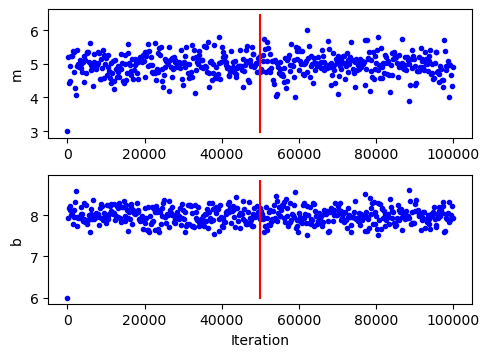

In [151]:
mcpl = mcstat.mcmcplot #this initializes the plotting methods
names = results['names']
chain = results['chain']
figcp = mcpl.plot_chain_panel(chain,names)
burnin = 50000
axes = figcp.get_axes()
for ii, ax in enumerate(axes):
    ch = chain[:, ii]
    ax.plot([burnin,burnin ], [ch.min(), ch.max()], 'r')

As we can see above,there are initially a few samples of m and b that are clearly way off the population.
This is the part of the chain that we discard since its believed that these values are not sampled from the stationary or posterior distributions. Literature says that this is the period where the means are said to transition and this is majorly due to the initial guess made.
For this example we will use the burnin period as 50000 (indicated by redline)
### Ananlyzing stats with burnin

In [152]:
mcstat.chainstats(chain[burnin:,:],results)



------------------------------
      name:      mean       std    MC_err       tau    geweke
         m:      4.97      0.34  4.18e-03      6.67      1.00
         b:      7.99      0.20  2.62e-03      6.49      1.00
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 32.53%
Stage 2: 52.25%
Net    : 84.79% -> 84788/100000
---------------
Chain provided:
Net    : 85.76% -> 42882/50000
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------


### geweke  
This is the Geweke's convergence criteria. Shows that for the burnin chain,it has converged to the stationary distribution which is the posterior distribution
### tau 
This is the autocorrelation time. Dont know what it means
### MC_err 
This is the normalized batch mean standard deviation

### Visulizing sampling history after burnin

<ipython-input-153-3a41e3c485d6>:1: DeprecationWarning: Call to deprecated function (or staticmethod) plot_chain_panel. (New function:"from pymcmcstat.mcmcplot import plot_chain_panel") -- Deprecated since version 1.9.0.
  figcp_burnin = mcpl.plot_chain_panel(chain[burnin:,:],names)


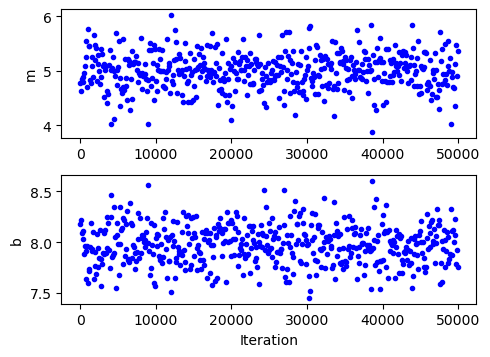

In [153]:
figcp_burnin = mcpl.plot_chain_panel(chain[burnin:,:],names)

### Visualizing the distribution
The package uses the Kernel Density Estimation (KDE) algorithm to go from the sampling above to the density plot - all with a single line of code

<ipython-input-154-dc6c1d532c8e>:1: DeprecationWarning: Call to deprecated function (or staticmethod) plot_density_panel. (New function: "from pymcmcstat.mcmcplot import plot_density_panel") -- Deprecated since version 1.9.0.
  figdp = mcpl.plot_density_panel(chain[burnin:,:],names)


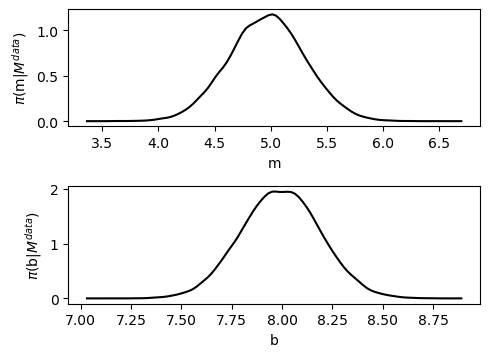

In [154]:
figdp = mcpl.plot_density_panel(chain[burnin:,:],names)

## Fitting the final model
Now we finally fit the model with the mean values of m and b that we obtained from mcmc.
We also plot along with it different prediction and credibility intervals
95% Credibility interval - the interval within which an unobserved parameter falls 95% of the time
95% Prediction interval - the probability of observing future numerical predictions or experimental obsrevations. Thus we expect a future observation to fall within that region 95% of the time

Generating credible/prediction intervals:


Interval generation complete



Text(0.5, 1.0, 'Final fitted model')

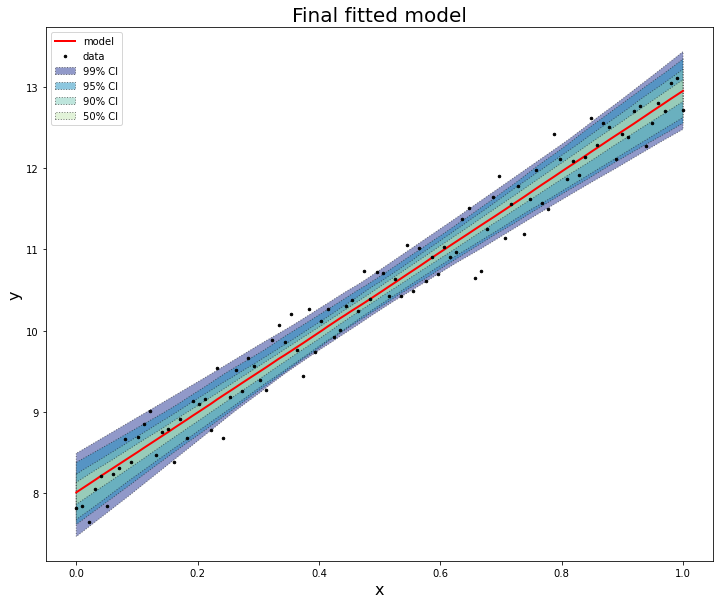

In [166]:
from pymcmcstat.MCMC import PredictionIntervals
PI = PredictionIntervals()
PI.setup_prediction_interval_calculation(results=results, data=mcstat.data,
    modelfunction=model, burnin=burnin)
PI.generate_prediction_intervals(calc_pred_int=True, waitbar=False)
fg, ax = PI.plot_prediction_intervals(adddata=True, plot_pred_int=True,
                                      figsizeinches=(10, 8), data_display=dict(color='k'))
ax[0].set_ylabel('y',fontsize = 16)
ax[0].set_xlabel('x',fontsize = 16)
ax[0].set_title('Final fitted model',fontsize = 20)

In [168]:
%load_ext watermark
%watermark --python
%watermark --iversions


ModuleNotFoundError: No module named 'watermark'